# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm, proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). The support webpage can be found here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm discovers the discords of arbitrary length in time series. It is worthwhile to note that the term arbitrary means the user can define a range for the length of discord (i.e. minimum length, `minL`, and maximum length, `maxL`). The algorithm finds discords of different lengths `L` $\in$ `[minL, maxL]`.

## What is a discord?
A subsequence of length `L` in a time series `T` is a discord **iff** it has the largest distance (hereafter being referred to as `discord_dist`) to its `[first]` nearest neighbor (`NN`). The neighbors of a subsequence of length `L`, starting at index `i`, is any other subsequences that start at an index `j`, such that `j!=i`. However, if `i` and `j` are very close to each other, the comparison between their corresponding subsequences is considered to be trivial. To this end, an exclusion zone (`excl_zone`) is taken into account to ignore the neighbors (i.e. subsequences) whose starting index is in numpy indexing `[i-excl_zone : i+excl_zone+1]`. 

**NOTE:** <br>
It is important to note that for the subsequenc `S = T[i:i+L]`, some of its neighbors are located on the left of `S` (i.e. the ones with starting index less than/equal to `max(0, i-excl_zone-1)`) and some of its neighbors are located on the right of `S` (i.e. the ones with starting index greater than/equal to `min(len(T), i+excl_zone+1)`). To find the `NN` of a subsequence `S`, the distance between `S` and all of its `[left and right]` neighbors must be obtained.

## Matrix Profile approach

How can we discover a discord of length `L` using matrix profile(`P`)? The solution is straightforward. `P` shows the distance of each subsequence to its `NN`. Therefore, the one that has the greatest distance to its `NN` is considered as the discord.

There are some advantages/disadvantages in using `P` when it comes to discovering discords:

* **Advantage:** <br>
Once we have the `P`, finding the discord is easy. Also, one can obtain the `top-k` discords very quickly by locating the first `k` largest distances in `P`.

* **Disadvantage:** <br>
`P` needs to be calculated for each new length `L` in `[minL, maxL]`, and, consequently, ALL pair-wise distances need to be calculated. Because, ALL pairwise distances are required for obtaining `P`. 

As will be shown later, `MERLIN` can skip some  of the pair-wise distance calculations. Also, it can use the `discord_dist` of length `L` to narrow down the search space for disovering the discord of length `L+1`.

## MERLIN

There are two main ideas at the core of the `MERLIN` algorithm. In below, we briefly explain each concept. Then, we will show its implementation and discuss its performance.

### Idea (1): Elimination Approach
The idea can be explained as follows: Suppose we are told that the discord distance (`discord_dist`) of length `L` is at least `min_dist` (Please note that the "how" of setting the `min_dist` value will be explained later in Idea(2)). That means the distance between the discord and each one of its neighbors is at least min_dist. We start scanning the subsequences. If, for a subsequence S, we realize that it has a neighbor to which its distance is smaller than `min_dist`, we can say S cannot be the discord. 

The main idea is to eliminate all subsequences for which there exist at least one neighbor with pair-wise distance less than `min_dist`. Therefore, the remaining subsequences (i.e. candidates) are the ones that have a distance great than/equal to `min_dist`. Now, we can find the `NN` of each candidate and choose the discord, i.e. the one that has the greatest distance to its `NN`. 

---

The smaller amount of candidates is the better. This is where choosing a good value for `min_dist` becomes important. For instance, let us consider two very extreme scenarios:

**Scenario I:** Choosing a VERY SMALL value for `min_dist`. In this case, we can end up with almost all subsequnces as the candidates.

**Scenario II:** Choosing a VERY LARGE value for `min_dist`. In this case, we can end up with no candidates at all. 

In below, we explain how MERLIN chooses the value for `min_dist`.

### Idea (2): Choosing `min_dist`
Let us assume we already discovered the discord `d` of length `L` whose distance to its NN (`d_NN`) is `discord_dist`. Now, to find the discord of length `L+1`, we can set `min_dist = discord_dist` if the distance is non-normalized Euclidean distance. The reason lies in the fact that increasing the length of subsequence results in an incease in the non-normalized Euclidean distance. In z-normalized Euclidean distance, however, increasing L may increase, decrease, or not change the distance. The authors of the [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) paper suggested a way to update `min_dist` for `L+1` based on the findings in `L`. We recommend interested reader to read the paper to understand their suggested approach. In the current implementation, however, we use `min_dist = discord_dist` (similar to the non-normalized case) as impelemented in the newer version of MERLIN.

We also need a way to set the value of `min_dist` for the discord of length `L = minL` in the beginning of the algorithm. We cannot use the `discord_dist` as we haven't discovered any discord yet! In this case, we set `min_dist` to the maximum possible distance that can exist between two subsequences (please see below for the math!). Then, if we find no candidates (similar to the Scenario II above), we can reduce the `min_dist`. 

---

**NOTE: z-normalized and non-normalized Euclidean distance**<br>
Please note that the [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) paper used z-normalized euclidean distance to calculate the distance between any two subsequence. In this work, our focus is on both normalized- and non-normalized- Euclidean distances. In the following, we will show how we can use dot product to calculate these two distances. Using dot product will help us to use the power of vectorization in the (more efficient) implementation of the  algorithm. Also, an inital value  for `min_dist` will be calculated that will be used in the beginning of the main (MERLIN) algorithm.

**z-normalizd Eucludiean distance ($ED_{z-norm}$):** <br>
$ED_{z-norm}$ and the Pearson correlation ($PC$), between any two subsequences with length $m$, are related as follows [(berthold2016)](https://arxiv.org/pdf/1601.02213.pdf):

$ED_{z-norm} = \sqrt{2 \times m \times (1-PC)}$ 

On the other hand, the $PC$ can be calculated as $PC = \frac{E[(X-\mu_{X})(Y-\mu_{Y})]}{\sigma_{X}\sigma_{Y}}$, which can be re-written as follows:

$PC = \frac{{\frac{1}{m}}{\sum\limits_{t=1}^{m}} {(X_{t} - \mu_{X})((Y_{t} - \mu_{Y}))}}{\sigma_{X}\sigma_{Y}}$.

Please note that a z-normalized subsequence has a mean ($\mu$) of 0 and standard deviation ($\sigma$) of 1. Therefore, the pearson correlation between two z-normalized subsequences becomes:

$PC = {\frac{1}{m}} <X_{z}, Y_{z}>$, where $<X_{z}, Y_{z}>$ is the dot product between two vectors $X_{z}$ and $Y_{z}$, where $X_{z}$ ($Y_{z}$) is a vector consists of the values of the subequene obtained by z-normalizing the subsequence $X$ ($Y$).


So, the first formula becomes: <br>
$ED_{z-norm} = \sqrt{2 \times m \times (1 - {\frac{1}{m}} <X_{z}, Y_{z}>)}$ 



Therefore, for a given $ED_{z-norm}$, one can calculate its corresponding dot product value as below: <br>
$<X_{z}, Y_{z}> = m \times (1 - \frac{1}{2m}{ED_{z-norm}^{2}})$ <br>
Thus, instead of comparing two z-normlized subsequences by calculating their (z-normlized) Euclidean distance, one can calculate the dot product of the two z-normalized subsequences. Please note that a higher Euclidean distance means lower dot product value. So, instead of using `min_dist` as the minimum distance a discord's candidate should have with all of its neighbors, one can use `r`, where $r = m \times (1 - \frac{1}{2m}{min\_dist^{2}})$, as the maximum dot product value a discord's candidate should have with its neighbors.

**Initial value for $ED_{z-norm}$**: <br>
As discussed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf), the initial value for `min_dist` is set to its maximum possible value. This can be achieved by choosing the lowest value for $PC$ (i.e. -1). In that case, it can be observed that the initial value for `min_dist` is $2\sqrt{m}$.

---
**non-normalizd Eucludiean distance ($ED$):** <br>
$ED$ can still be calculated by the help of some dot products: <br>

$ED^{2} = {||X-Y||}^{2}  =  <X-Y , X-Y>  =  <X.X> + <Y.Y>  -  2<X,Y>$ <br>
Using the right hand side of the equation above may not make sense when we are iterating the subsequences in a for-loop one by one. However, in the more efficient version of MERLIN, where candidates are compared to more than one subsequencec in each iteration, this relationship can be helpful. We can calculate and store the two-norm of all subsequences in a 1-dim array. Then, we can use np.matmul() to calculate the last term (i.e. $<X,Y>$). We can get into further details later in the implementation.

**Initial value for $ED$**: <br>
Similar to the z-normalized case, we would like to set the value of the `min_dist` to the maximum possible value. Therefore:

$min\_dist^{2} = max ({||X-Y||}^{2}) = max \sum\limits_{t=1}^{m}(X_{t} - Y_{t})^{2} =  \sum\limits_{t=1}^{m}max{(X_{t} - Y_{t})^{2}} = \sum\limits_{t=1}^{m}{[max (|X_{t} - Y_{t}|)]}^{2} =  \sum\limits_{t=1}^{m}{(T_{max} - T_{min})^2} = {m} \times{(T_{max} - T_{min})^2}$

where, $T_{max}$ ($T_{min}$) is the maximum (minimum) value of the main time series $T$.

And, this gives the maximum possible value for `min_dist` as follows: <br>
$ min\_dist = (|T_{max} - T_{min}|) \sqrt{m}$

## Implement MERLIN
It is worthwhile to note that a faster version of MERLIN is provided on the MERLIN's support webpage [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies). However, for now, we implement the version proposed in the original paper as it can be implemented in a cleaner/more understandable way.

### Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
from stumpy import core, config
import numpy as np
import matplotlib.pyplot as plt
import math
import time

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

### Import (toy) data
data set is available at: 
https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view


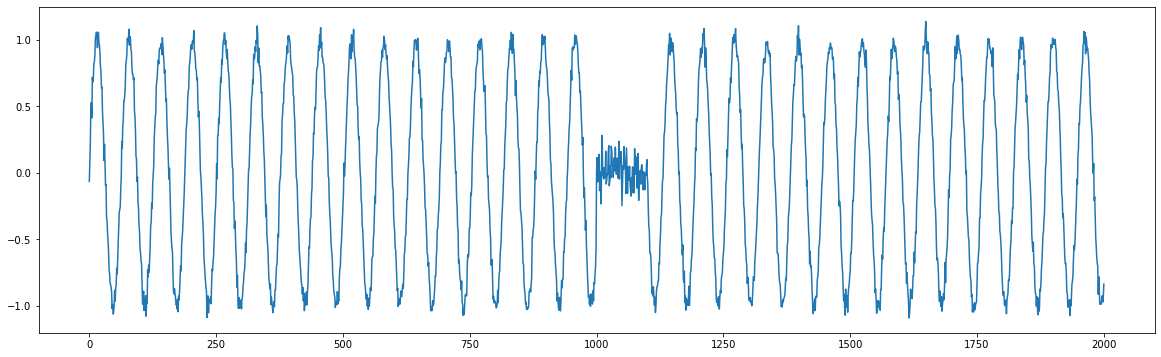

In [2]:
from scipy.io import loadmat

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

#visualize data
plt.plot(ts)
plt.show()

As we can see there is an anomaly located in about the middle of the time series data. Next, we will implement and then use MERLIN to discover the discord.

### MERLIN- Part (I): DRAG --> Selecting Candidates \[for discord of length L\]
As explained before, the idea is to select a number of candidates by eliminating undesirable subsequences. A candidate is a subsequence whose distance to all of its neighbors are at least `min_dist` (then, we can search among these candidates and find the discord) Since some neighbors of a subsequence is located on its left and others on its right, this part can be done in two phases as follows 

**MERLIN-Part(I): DRAG - Phase (I) --> Select Candidates** <br>
It is important to note that the term "candidates" in "select candidates" is different than the one we discussed so far. Here, some of the candidates (as will be explained shortly) might be false positive! That means, they HAVE a neighbor to which their distance is smaller than `min_dist`. These false positives will be pruned in the second phase of DRAG. 

In this phase, we compare each subsequence (i.e. potential candidate) with ALL of its RIGHT neighbors by calculating their dot product (instead of their euclidean distance). **NOTE:** We might end up with some false positives because we haven't check the LEFT neighbors YET. We compare each candidate with its LEFT neighbors in the second phase (to prune the false positives).

In [3]:
def _select_candidates(subseqs, min_dist):
    """
    For a time series T, this function finds a set of candidates whose distance to all of their RIGHT neighbors is 
    at least min_dist. 
    
    Parameters
    ---------
    subseqs: ndarray 
    subseqs[i,:] contains a z-normalized subsequence of the main time series that starts at index "i".
    NOTE: This 2-dim array can take a lot of memory for VERY LONG time seris. This should be changed in later iterations.
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    
    output
    --------
    is_cands: boolean numpy array
    is_cands[i] is True if i is the starting index of a candidate (may contain false positives! see Note below.)
    
    NOTE:
    In this function, the selected candidates are gauranteed to have minimum distance of min_dist to 
    ALL of their RIGHT neighbors. Since we haven't checked them yet with their LEFT neighbors, some of the candidates 
    might be false positive, i.e. they have at least one LEFT neighbor to which their distance is less than min_dist.
    """    
    n, m = subseqs.shape # n: number of subsequences, #m: length of each subsequence
    is_cands = np.zeros(n, dtype=bool)
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    r = m * (1.0 - ((min_dist ** 2.0) / (2.0 * m))) 

    for i in range(0, n):
        add_cand_i = True
        
        if i > excl_zone:
            left_non_trivial_cand_idx = np.flatnonzero(is_cands[:i-excl_zone])
            R = np.matmul(subseqs[left_non_trivial_cand_idx], subseqs[i])
            mask = np.flatnonzero(R > r)
            is_cands[left_non_trivial_cand_idx[mask]] = False

            if len(mask):
                add_cand_i = False
        
        if add_cand_i:
            is_cands[i] = True
            
    return is_cands

In [4]:
#input (as provided by the  authors of paper)
m = 512 
min_dist = 10.27 #min_dist is not required for MERLIN. This is just to show the code works.

subseqs = core.z_norm(core.rolling_window(ts, m), axis=1)

In [5]:
is_cands = _select_candidates(subseqs, min_dist)
cand_index = np.flatnonzero(is_cands)
cand_index

array([ 584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
        595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  677,  678,  679,
        680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
        691,  692,  693,  694,  695,  696,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  749,  750,  751,  780,  781,
        906,  907,  908, 1361, 1362, 1363, 1364, 1367, 1368, 1369, 1370,
       1371, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388,
       1393, 1394, 1395, 1396, 1400, 1401, 1402, 1403, 1404, 1405, 1406,
       1407, 1408, 1409, 1410, 1411, 1415, 1416, 1417, 1418, 1419, 1421,
       1422, 1423, 1424, 1425, 1426, 1427, 1428, 14

The number of so-far-selected candidates (188) are about one-tenth of total number of subsequences (1490). Also, some of them might be False Positives (that will be handled in the second phase.). 

Let's see if the anomaly part of the time series is covered by the selected candidates:

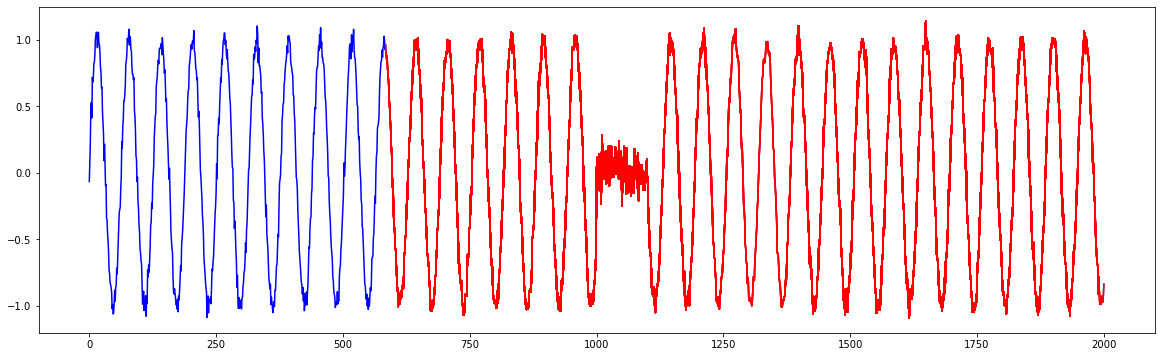

In [6]:
plt.plot(ts, c='b')
for idx in cand_index:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated, the selected candidates cover the anomaly. Next, we implement the second phase of DRAG, Prune Candidates, which is basically just comparing the selected candidates with their LEFT neighbors. 

**MERLIN-Part(I): DRAG - Phase (II) --> Prune Candidates**<br>
In this phase, we compare the selected candidate with their LEFT neighbors. The goal is to prune any candidate that has at least one left neighbor to which its distance is less than `min_dist`. So, at the end of this process, the remaining candidates are the ones that have a minimum distance of `min_dist` to all of their neighbors.

In [7]:
def _prune_candidates(subseqs, min_dist, is_cands):
    """
    For a time series T, this function prunes a set of candidates by comparing them with (all of) their LEFT neighbors. A
    selected candidate will be removed if it has at least one left neighbor to which its distance is less than `min_dist`. 
    
    Parameters
    ---------
    subseqs: ndarray 
    subseqs[i,:] contains a z-normalized subsequence of the main time series that starts at index "i".
    NOTE: This 2-dim array can take a lot of memory for VERY LONG time seris. This should be changed in later iterations.
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    is_cands: boolean numpy array
    the output of the function `_select_candidates`. 
    is_cand[i] is True if the subsequence starting at index i is selected as a candidate by the _select_candidates function.
    
    
    output
    --------
    is_cands: boolean numpy array
    is_cands[i] is True if i is the starting index of a candidate
    
    NOTE:
    Any candidate discovered here is guaranteed to have minimum distance of min_dist to ALL of its neighbors.
    """    
    n, m = subseqs.shape # n: number of subsequences, #m: length of each subsequence
    
    cands_idx = np.flatnonzero(is_cands)
    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    r = m * (1.0 - ((min_dist ** 2.0) / (2.0 * m))) 

    for i in range(0, n):
        if not np.any(is_cands):
            break #means all candidates are pruned! no need to check further! There is nothing to return!
        
        non_trivial_cand = cands_idx[cands_idx > i + excl_zone] 
        
        if not len(non_trivial_cand):
            break #means we already reached a subsequence that has no candidates on its right neighbors!
        
        R = np.matmul(subseqs[non_trivial_cand], subseqs[i])
        mask = np.flatnonzero(R > r)
        is_cands[non_trivial_cand[mask]] = False
        
        
    return is_cands

In [8]:
cands = np.flatnonzero(_prune_candidates(subseqs, min_dist, is_cands))
cands

array([592, 593, 594, 621, 622, 623, 624, 625, 626, 627, 652, 653, 654,
       655, 656, 657, 658, 659, 683, 684, 685, 686, 687, 688, 689, 690,
       691, 715, 716, 717, 718, 719, 720, 749, 750, 751, 780, 781, 906,
       907, 908], dtype=int64)

The number of final candidates (41) is about 3% of total number of subsequences (1490). In other words, out of the initial number of candidates (i.e. 1490), we just need to search among the 41 final candidates. We should note that choosing different values for `min_dist`can affect the performance of the algorithm (see Fig. 5 of the paper). For instance, choosing a very large value for `min_dist` may result in no candidates while choosing a very small value may result in a lot of candidates. Therefore, the algorithm should use a sound approach for adjusting `min_dist`. We will further discuss this matter when we implement the MERLIN algorithm itself. 

**Check if the dicord is covered by (some of) final candidates** <br>
Let us see if the anomaly part of the time series is covered by these final candidates:

NameError: name 'cand' is not defined

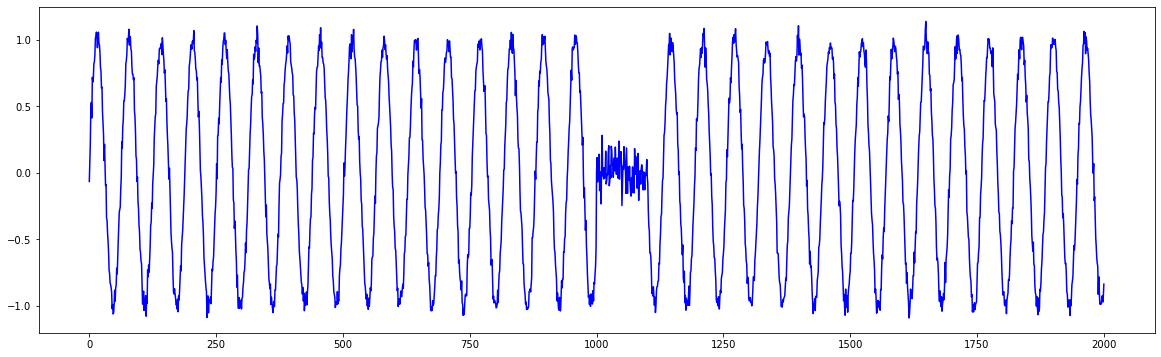

In [9]:
plt.plot(ts, c='b')
for idx in cand:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated in the figure above, the left candidate covers the anomaly of the time series data. Please note that it is possible that some of the candidates may not cover the anomaly. For example, recall the scenario where `min_dist` is very small. In that case, most subsequences are going to be returned as candidates. So, it is not reasonable to expect the most left and/or right candidates (and/or some other candidates) cover the anomaly in all cases. 

We can still find the discord! As will be shown in the next step,  we will find the NN of each of the final candidates, and choose the candidate that has the greatest distance to its NN. 

**MERLIN-Part(I): DRAG - Phase (III) --> Find Discord**<br>
After pruning the false positive candidates, we can find the NN of each of the remaining candidates. The candidate that has the greatest distance to its NN is the (top) discord.

In [12]:
def _find_discord(subseqs, cands):
    """
    For a time series T, this function finds the discord by searching among the chosen candidates.
 
    Parameters
    ---------
    subseqs: ndarray 
    subseqs[i,:] contains a z-normalized subsequence of the main time series that starts at index "i".
    NOTE: This 2-dim array can take a lot of memory for VERY LONG time seris. This should be changed in later iterations.
    
    cands: numpy array
    It contains the starting index of chosen candidates
    
    
    output
    --------
    discord_idx: int 
    the index of the discord
    
    discord_dist: float
    the distance of the discord to its nearest neighbor
    
    discord_NN_idx: int
    the index of the discord's nearest neighbor
    """    
    n, m = subseqs.shape
    
    n_cands = len(cands)
    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))

    # we first find NN of each cand and their corresponing r (see two lines below followed by the for-loop) 
    cands_r = np.zeros(n_cands) 
    cands_NN = np.empty(n_cands, dtype='int64')
    
    for i, idx in enumerate(cands): #find NN of each candidate and their corresponding dot product value
        R = np.matmul(subseqs, subseqs[idx])
        R[max(0, idx - excl_zone) : min(n, idx + excl_zone + 1)] = np.NINF
        NN_loc = np.argmax(R)
        cands_NN[i] = NN_loc
        cands_r[i] = R[NN_loc]
    
    # Now, we search to find the top discord 
    # i.e. the candidate with highest dist to its NN, which is equivalent to lowest value r stored in cands_r
    pos = np.argmin(cands_r) # between idx, loc, and pos (position), I chose pos as the name.
    
    discord_idx = cands[pos]
    discord_dist = np.sqrt(2 * m * (1 - (cands_r[pos] / m))) ##convert r back to z-normalized ED
    discord_NN_idx = cands_NN[pos]
    
    return discord_idx, discord_dist, discord_NN_idx

In [13]:
discord_idx, discord_dist, discord_NN_idx = _find_discord(subseqs, cands)

print('the index of discord is: ', discord_idx)
print('dist of discord to its NN is: ', discord_dist)
print('the index of NN of the discord: ', discord_NN_idx)

the index of discord is:  718
dist of discord to its NN is:  10.301397123539061
the index of NN of the discord:  278


**Now, let us use matrix profile (of stumpy package) to make sure the output is correct:**

In [14]:
mp = stumpy.stump(ts, m)
p = mp[:,0] #p: matrix profile (dist of each subseq to its NN)
pos = np.argmax(p)

mp_discord_idx = pos
mp_discord_dist = p[pos]
mp_discord_NN_idx = mp[pos,1]

print('>>> using matrix profile to find the discord <<< \n')
print('the index of discord is: ', discord_idx)
print('dist of discord to its NN is: ', discord_dist)
print('the index of NN of the discord: ', discord_NN_idx)

>>> using matrix profile to find the discord <<< 

the index of discord is:  718
dist of discord to its NN is:  10.301397123539061
the index of NN of the discord:  278
